## Distribution Errors

In [1]:

import torch
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
from BronchoTrack.metrics import DirectionError, EuclideanDistance, NeedleError

from matplotlib.ticker import PercentFormatter


tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 15,
    "font.size": 15,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.bottom" : True, 
    "ytick.left" : True,
    "axes.spines.bottom": True,
    "axes.spines.left": True,
    "axes.spines.right": True,
    "axes.spines.top": True,
}

plt.rcParams.update(tex_fonts)

def compute_errors(data_vector):
    angles = torch.tensor(data_vector[3:6], dtype=torch.float32)
    pos = torch.tensor(data_vector[0:3], dtype=torch.float32)
    all_pa = torch.tensor(data_vector[0:6], dtype=torch.float32)
    ground = torch.zeros(3, dtype=torch.float32)
    ground_a = torch.ones(3, dtype=torch.float32)
    ground_extra = torch.zeros(6, dtype=torch.float32)
    de = DirectionError.inverse_cos(ground_a, angles).numpy()
    pe = EuclideanDistance.euclidean(ground, pos).numpy()
    ne = NeedleError.needle(ground_extra, all_pa).numpy()
    return [de, pe, ne]

def compute_distribution(globfolder):
    errors = []
    for csv in glob.glob(globfolder):
        df = pd.read_csv(csv, index_col=0).iloc[1:, -6:].values
        errors.append(np.apply_along_axis(compute_errors, 1, df))
    return np.concatenate(errors, 0)

In [2]:
train_errors = compute_distribution("../data/cleaned/train/*.csv")
val_errors = compute_distribution("../data/cleaned/val/*.csv")
test_errors = compute_distribution("../data/cleaned/test/*.csv")

ValueError: need at least one array to concatenate

In [7]:
def plot_error_dist(index, savepath, xlabel, ylabel=True):
    fig, ax = plt.subplots(figsize=(8, 6))
    # ax = sns.distplot(train_errors[:, index], bins=100, hist=False, kde_kws={"shade":True, "linewidth":1}, label="Train", ax=ax)
    ax = sns.kdeplot(train_errors[:, index], shade=True, linewidth=1, label="Train", ax=ax)
    ax = sns.kdeplot(val_errors[:, index],  shade=True, linewidth=1, label="Val", ax=ax)
    #ax = sns.kdeplot(test_errors[:, index],  shade=True, linewidth=1,label="Test", ax=ax)
    ax.yaxis.set_major_formatter(PercentFormatter(1 / 0.01))
    # ax = sns.histplot(data=penguins, x="flipper_length_mm", kde=True, stat="probability", color="r", label="Probabilities",
    #          binwidth=binwidth, ax=ax1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4)
    plt.legend(fontsize=20)
    plt.xlabel(xlabel, fontsize=30)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    if ylabel:
        plt.ylabel('Density', fontsize=30)
    else:
        ax.set(ylabel=None)
    plt.tight_layout()
    fig.savefig(savepath, format='pdf', bbox_inches='tight')

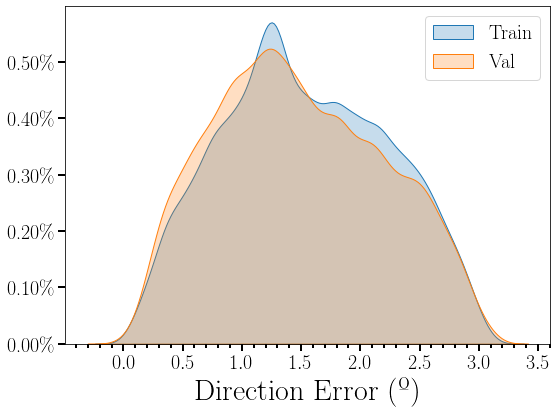

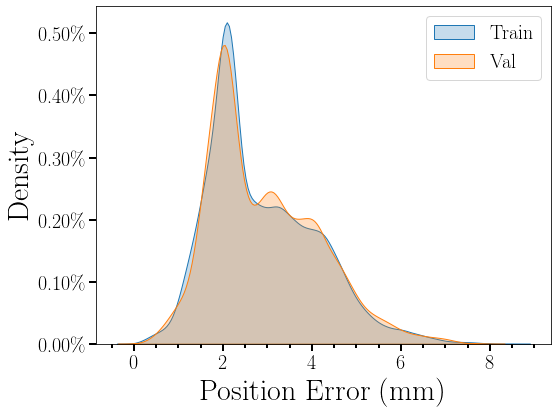

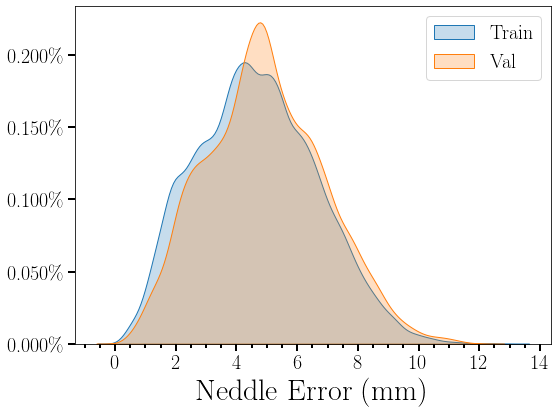

In [8]:
plot_error_dist(0, "de.pdf", "Direction Error (º)", False)
plot_error_dist(1, "pe.pdf", "Position Error (mm)", True)
plot_error_dist(2, "ne.pdf", "Neddle Error (mm)", False)

# Sample trajectories

In [94]:
%matplotlib notebook
def paths(globfolder, train=False, lobe="ur"):
    errors = []
    for csv in glob.glob(globfolder):
        if train:
            if "P25" in csv and lobe in csv:
                df = pd.read_csv(csv, index_col=0).iloc[1:, 2:5].values
                errors.append(df)
        else:
            df = pd.read_csv(csv, index_col=0).iloc[1:, 2:5].values
            errors.append(df)
    return np.concatenate(errors, 0)

In [95]:
test_paths = paths("../data/cleaned/test/*.csv")
val_paths = paths("../data/cleaned/val/*.csv")
train_paths = paths("../data/cleaned/train/*.csv", True, "ur")
train_paths_bl = paths("../data/cleaned/train/*.csv", True, "bl")
train_paths_ul = paths("../data/cleaned/train/*.csv", True, "ul")
train_paths_br = paths("../data/cleaned/train/*.csv", True, "br")


<IPython.core.display.Javascript object>


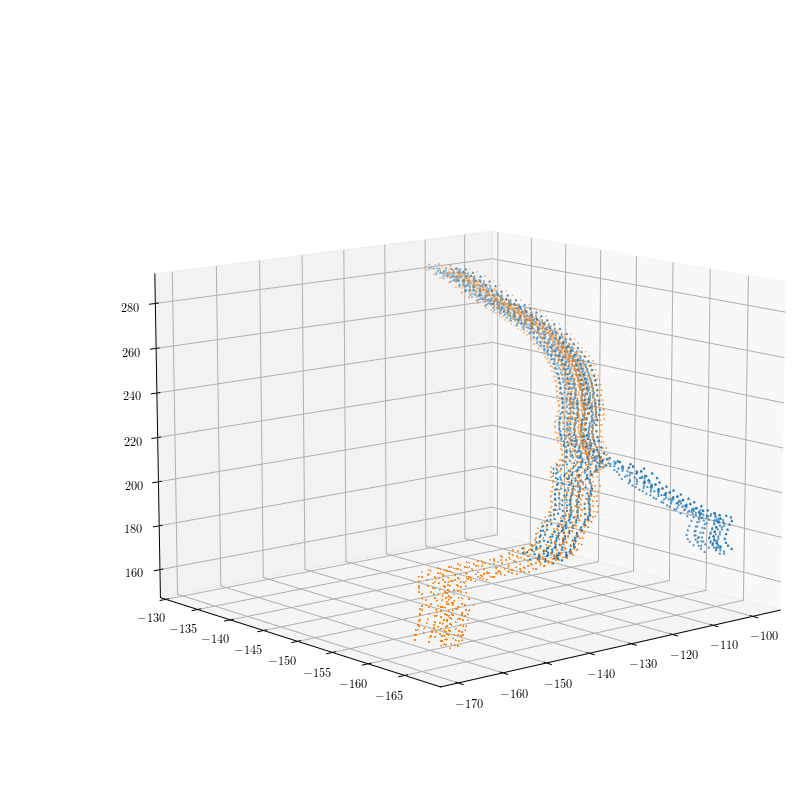

In [96]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(test_paths[:, 0], test_paths[:, 1], test_paths[:, 2], marker="^",s=1)
ax.scatter(val_paths[:, 0], val_paths[:, 1], val_paths[:, 2], marker="+",s=1)
ax.view_init(30, 200)

<IPython.core.display.Javascript object>


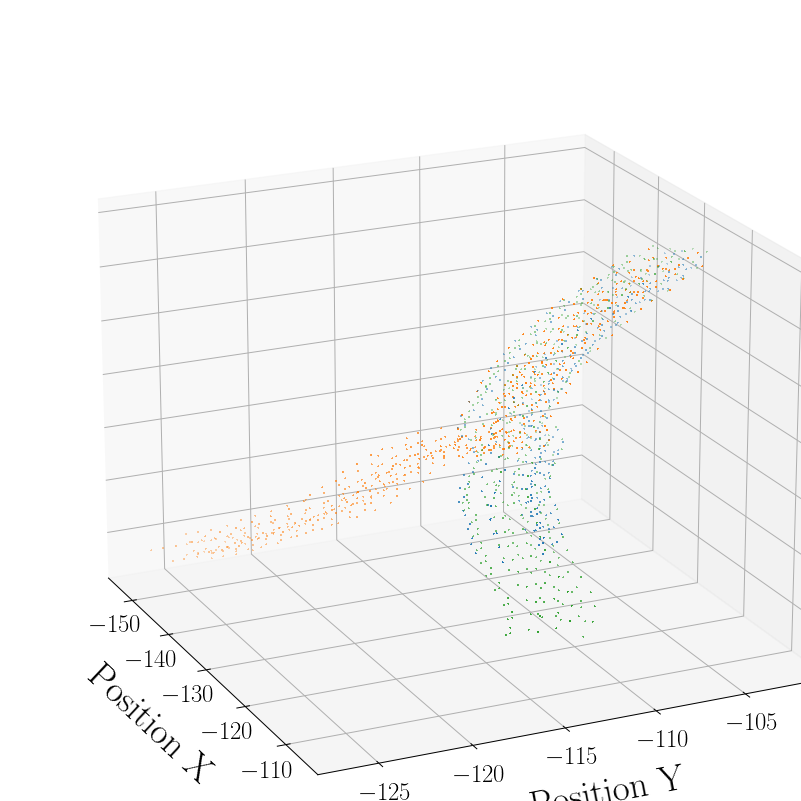

In [97]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
#ax.scatter(test_paths[:, 0], test_paths[:, 1], test_paths[:, 2], marker="^",s=1)
#ax.scatter(val_paths[:, 0], val_paths[:, 1], val_paths[:, 2], marker="+",s=1)
ax.scatter(train_paths[:, 0], train_paths[:, 1], train_paths[:, 2], marker="+",s=1)
ax.scatter(train_paths_bl[:, 0], train_paths_bl[:, 1], train_paths_bl[:, 2], marker="+",s=1)
ax.scatter(train_paths_br[:, 0], train_paths_br[:, 1], train_paths_br[:, 2], marker="+", s=1)
#ax.scatter(train_paths_ur[:, 0], train_paths_ur[:, 1], train_paths_ur[:, 2], marker="b^", s=1)

ax.view_init(20, -25)
ax.set_ylabel("Position Y", fontsize=30, labelpad=20)
ax.set_xlabel("Position X", fontsize=30, labelpad=20)
ax.set_zlabel("Position Z", fontsize=30, labelpad=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.zaxis.set_tick_params(labelsize=20)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
fig.savefig("sample_traj.pdf", format='pdf', bbox_inches='tight')

# N Images

In [98]:
def compute_len(globfolder):
    errors = []
    for csv in glob.glob(globfolder):
        df = pd.read_csv(csv, index_col=0).iloc[1:, -6:].values
        errors.append(len(df))
    return np.sum(errors)

In [99]:
compute_len("../data/cleaned/test/*.csv"), compute_len("../data/cleaned/train/*.csv"),  compute_len("../data/cleaned/val/*.csv")

(1890, 10440, 1800)

# Draw Central Paths

In [100]:
from collections import defaultdict
root = "/mnt/DADES/datasetcalibracio/"
patients = ["P25", "P18", "P20", "P21", "P30"]
lobes = ["ur", "ul", "br", "bl"]
columns_use = ["pos_x", "pos_y", "pos_z"]

In [101]:
def get_central_paths():
    patient_dict = defaultdict(dict)
    for p in patients:
        for csv in glob.glob(os.path.join(root, "*" + p + "*CPAP.csv")):
            sample_df = pd.read_csv(csv)
            for lobe in lobes:
                lobe_df = sample_df[sample_df["lobe"] == lobe].copy().reset_index()
                lobe_df["isStatusChanged"] = lobe_df["base_filename"].shift(
                    1, fill_value=lobe_df["base_filename"].head(1)) != lobe_df["base_filename"]
                change_indexes = np.insert(
                    lobe_df.loc[lobe_df["isStatusChanged"], :].index.values, 0, 0)
                seq_level_lobe_df = lobe_df.loc[
                    change_indexes, columns_use,
                ].copy().reset_index().values
                patient_dict[p][lobe] = seq_level_lobe_df
    return patient_dict

In [102]:
patient_dict = get_central_paths()

In [103]:
patient_dict["P25"]["bl"]

array([[    0.   ,  -124.54 ,  -103.436,   166.979],
       [  876.   ,  -124.852,  -104.244,   165.417],
       [ 1752.   ,  -124.939,  -105.306,   163.601],
       [ 2628.   ,  -125.069,  -106.001,   161.862],
       [ 3504.   ,  -125.47 ,  -106.932,   160.198],
       [ 4380.   ,  -125.629,  -107.483,   158.846],
       [ 5256.   ,  -125.788,  -108.222,   156.827],
       [ 6132.   ,  -125.844,  -109.057,   154.742],
       [ 7008.   ,  -125.829,  -109.871,   152.688],
       [ 7884.   ,  -125.805,  -110.503,   150.578],
       [ 8760.   ,  -125.844,  -110.974,   148.972],
       [ 9636.   ,  -125.999,  -111.349,   147.012],
       [10512.   ,  -126.301,  -111.509,   145.291],
       [11388.   ,  -126.386,  -111.928,   143.588],
       [12264.   ,  -126.237,  -112.383,   141.492],
       [13140.   ,  -125.66 ,  -112.738,   139.476],
       [14016.   ,  -125.717,  -112.601,   137.513],
       [14892.   ,  -126.604,  -112.66 ,   135.973],
       [15768.   ,  -127.918,  -113.166,   135

<IPython.core.display.Javascript object>


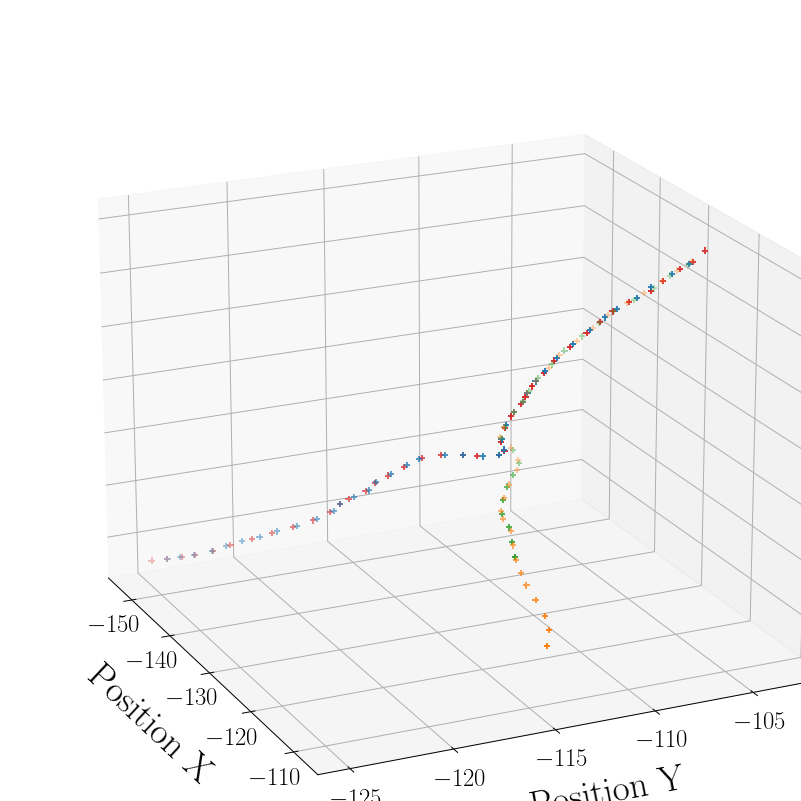

In [104]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(patient_dict["P25"]["bl"][:, 1], patient_dict["P25"]["bl"][:, 2], patient_dict["P25"]["bl"][:, 3], marker="+",s=25)
ax.scatter(patient_dict["P25"]["br"][:, 1], patient_dict["P25"]["br"][:, 2], patient_dict["P25"]["br"][:, 3], marker="+",s=25)
ax.scatter(patient_dict["P25"]["ur"][:, 1], patient_dict["P25"]["ur"][:, 2], patient_dict["P25"]["ur"][:, 3], marker="+",s=25)
ax.scatter(patient_dict["P25"]["ul"][:, 1], patient_dict["P25"]["ul"][:, 2], patient_dict["P25"]["ul"][:, 3], marker="+",s=25)
#ax.scatter(train_paths_bl[:, 0], train_paths_bl[:, 1], train_paths_bl[:, 2], marker="+",s=1)
#ax.scatter(train_paths_br[:, 0], train_paths_br[:, 1], train_paths_br[:, 2], marker="+", s=1)
#ax.scatter(train_paths_ur[:, 0], train_paths_ur[:, 1], train_paths_ur[:, 2], marker="b^", s=1)

ax.view_init(20, -25)
ax.set_ylabel("Position Y", fontsize=30, labelpad=20)
ax.set_xlabel("Position X", fontsize=30, labelpad=20)
ax.set_zlabel("Position Z", fontsize=30, labelpad=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.zaxis.set_tick_params(labelsize=20)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
fig.savefig("sample_traj.pdf", format='pdf', bbox_inches='tight')

# Losses

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

tex_fonts = {
    # Use LaTeX to write all text
    "font.family": "serif",
}

plt.rcParams.update(tex_fonts)


In [3]:
cosin = pd.read_csv("run-BronchoModelLossP18_1_bronchonet_15traj_COS-tag-Train Direction Error.csv")
de = pd.read_csv("run-BronchoModelLossP18_1_bronchonet_15traj_DE-tag-Train Direction Error.csv")
mse = pd.read_csv("run-BronchoModelLossP18_1_bronchonet_15traj_MSE-tag-Train Direction Error.csv")
quaternion = pd.read_csv("run-BronchoModelLossP18_1_bronchonet_15traj_QUAT-tag-Train Direction Error.csv")


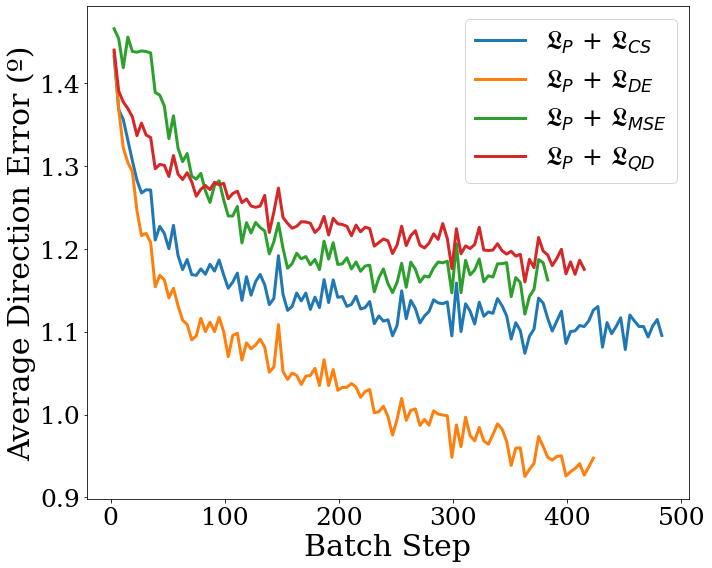

In [4]:
plt.figure(figsize=(10,8))
plt.plot(cosin["Step"], cosin["Value"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{CS}$', lw=3)
plt.plot(de["Step"], de["Value"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{DE}$ ', lw=3)
plt.plot(mse["Step"], mse["Value"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{MSE}$', lw=3)
plt.plot(quaternion["Step"], quaternion["Value"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{QD}$', lw=3)
plt.legend(fontsize=25)
plt.ylabel("Average Direction Error (º)", fontsize=30)
plt.xlabel("Batch Step", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.tight_layout()
plt.savefig("loss_plot.pdf", format='pdf', bbox_inches='tight')

Now cross patient

In [90]:
def build_common_error(root="./lossplots/", patients=["P18", "P21", "P20", "P30", "P25"], losses=["COS", "MSE", "QUAT", "DE"]):
    subfiles = {i: [os.path.join(root, file) for file in os.listdir(root) if i in file] for i in losses}
    whole = pd.DataFrame()
    
    for key in subfiles:
        values = pd.DataFrame()
        for file in subfiles[key]:
            df = pd.read_csv(file)
            values = pd.concat([values, df["Value"].rename(file.split("_")[-2])], axis=1)
        whole = pd.concat([whole, values.mean(axis=1).rename(key)], axis=1)
        whole = pd.concat([whole, values.std(axis=1).rename(key + "_std")], axis=1)
    for key in losses:
        whole[key + "_std"].fillna(whole[key + "_std"].max(), inplace=True)
    
    return whole

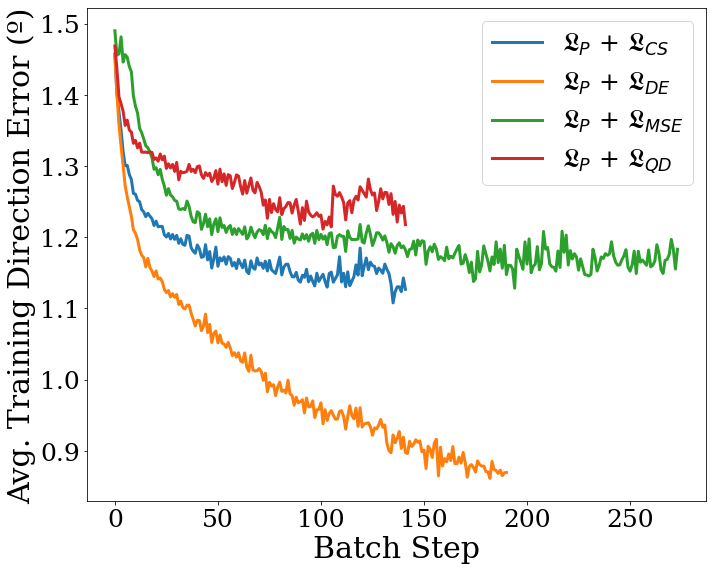

In [91]:
whole = build_common_error()
plt.figure(figsize=(10,8))
plt.plot(whole.index, whole["COS"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{CS}$', lw=3)
plt.plot(whole.index, whole["DE"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{DE}$ ', lw=3)
plt.plot(whole.index, whole["MSE"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{MSE}$', lw=3)
plt.plot(whole.index, whole["QUAT"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{QD}$', lw=3)
plt.legend(fontsize=25)
plt.ylabel("Avg. Training Direction Error (º)", fontsize=30)
plt.xlabel("Batch Step", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.tight_layout()
plt.savefig("loss_plot.pdf", format='pdf', bbox_inches='tight')

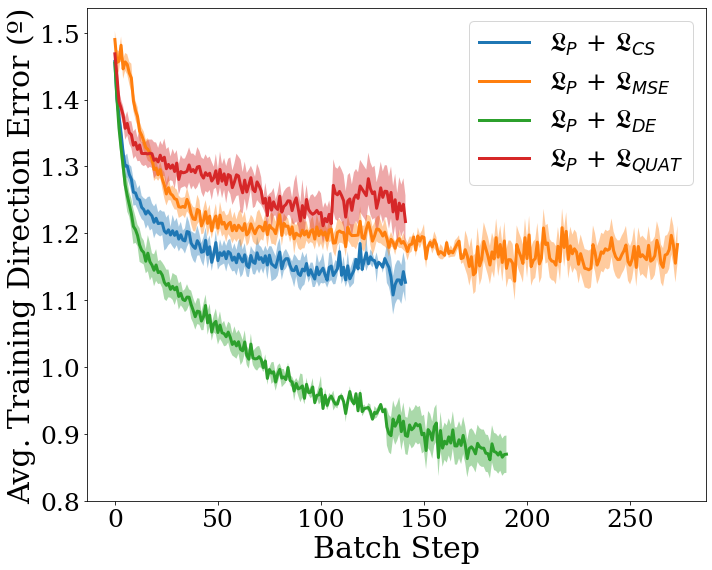

In [92]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(whole.index, whole["COS"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{CS}$', lw=3)
ax.fill_between(whole.index.astype(float), whole["COS"] - whole["COS_std"]/2, whole["COS"] + whole["COS_std"]/2, alpha=0.4)
ax.plot(whole.index, whole["MSE"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{MSE}$', lw=3)
ax.fill_between(whole.index.astype(float), whole["MSE"] - whole["MSE_std"]/2, whole["MSE"] + whole["MSE_std"]/2, alpha=0.4)
ax.plot(whole.index, whole["DE"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{DE}$', lw=3)
ax.fill_between(whole.index.astype(float), whole["DE"] - whole["DE_std"]/2, whole["DE"] + whole["DE_std"]/2, alpha=0.4)
ax.plot(whole.index, whole["QUAT"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{QUAT}$', lw=3)
ax.fill_between(whole.index.astype(float), whole["QUAT"] - whole["QUAT_std"]/2, whole["QUAT"] + whole["QUAT_std"]/2, alpha=0.4)

plt.legend(fontsize=25)
plt.ylabel("Avg. Training Direction Error (º)", fontsize=30)
plt.xlabel("Batch Step", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.tight_layout()
plt.savefig("loss_plot_std.pdf", format='pdf', bbox_inches='tight')

In [84]:
whole

,COS,COS_std,MSE,MSE_std,QUAT,QUAT_std,DE,DE_std
0,1.457132,0.027110,1.489797,0.026146,1.468413,0.029321,1.454689,0.020966
1,1.400837,0.030721,1.455424,0.037415,1.435628,0.049465,1.401092,0.026196
2,1.375162,0.034357,1.457459,0.029678,1.396722,0.035750,1.357290,0.037570
3,1.350119,0.027390,1.481244,0.026190,1.387505,0.024992,1.327688,0.044567
4,1.320101,0.025894,1.445851,0.029836,1.376691,0.026937,1.300730,0.039807
...,...,...,...,...,...,...,...,...
269,NaN,0.009324,1.175584,0.013532,NaN,0.033303,NaN,0.007421
270,NaN,0.009324,1.196916,0.013532,NaN,0.033303,NaN,0.007421
271,NaN,0.009324,1.182751,0.013532,NaN,0.033303,NaN,0.007421
272,NaN,0.009324,1.155144,0.013532,NaN,0.033303,NaN,0.007421


# Draw trajectory

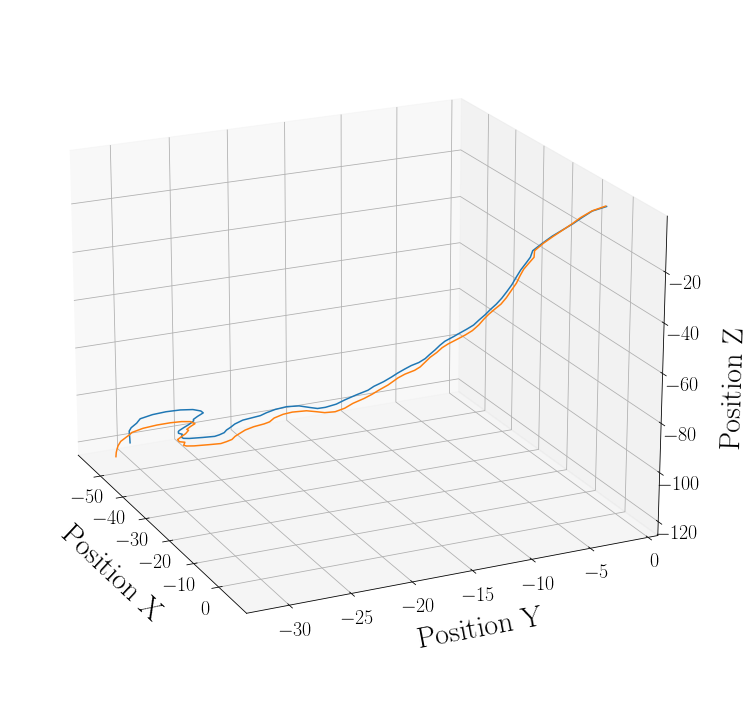

In [3]:
#data = pd.read_csv("../data/cleaned/loss_intra/preds_30traj_COS_EU/LENS_P18_14_01_2016_INSP_CPAP_bl_4.csv")
data = pd.read_csv("../data/cleaned/data_increase/intra_120/preds_120traj_COS_EU_intra/LENS_P18_14_01_2016_INSP_CPAP_bl_4.csv")
acum = data.cumsum()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.plot3D(acum.loc[:, "shift_x"], acum.loc[:, "shift_y"], acum.loc[:, "shift_z"])
ax.plot3D(acum.loc[:, "gt_shift_x"], acum.loc[:, "gt_shift_y"], acum.loc[:, "gt_shift_z"], )

ax.view_init(20, -25)
ax.set_ylabel("Position Y", fontsize=30, labelpad=20)
ax.set_xlabel("Position X", fontsize=30, labelpad=20)
ax.set_zlabel("Position Z", fontsize=30, labelpad=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.zaxis.set_tick_params(labelsize=20)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
fig.savefig("sample_traj_intra_loss.pdf", format='pdf', bbox_inches='tight')

    Unnamed: 0    shift_x    shift_y     shift_z     Rx_dif     Ry_dif  \
0            0  -0.268178  -1.248156   -0.760913   0.730522   2.308562   
1            1  -0.374357  -2.375221   -1.783907  -4.704179   4.231355   
2            3  -0.081537  -3.256321   -3.387677  -6.033586   4.684730   
3            6   0.099783  -4.072176   -5.247660  -7.403335   5.569393   
4           10   0.217504  -4.922369   -7.020978 -10.001326   7.339092   
..         ...        ...        ...         ...        ...        ...   
77        3003 -53.749503 -30.479539 -112.545846 -12.341266 -27.570102   
78        3081 -54.043931 -30.582628 -114.353948  -9.814065 -29.053711   
79        3160 -54.308607 -30.665188 -115.989638  -7.948752 -30.538510   
80        3240 -54.583842 -30.592960 -118.125220  -5.861096 -32.208444   
81        3321 -54.963546 -30.565633 -120.235813  -4.580790 -33.015239   

      Rz_dif  gt_shift_x  gt_shift_y  gt_shift_z  gt_Rx_dif  gt_Ry_dif  \
0  -0.044999      -0.509      -1.361 

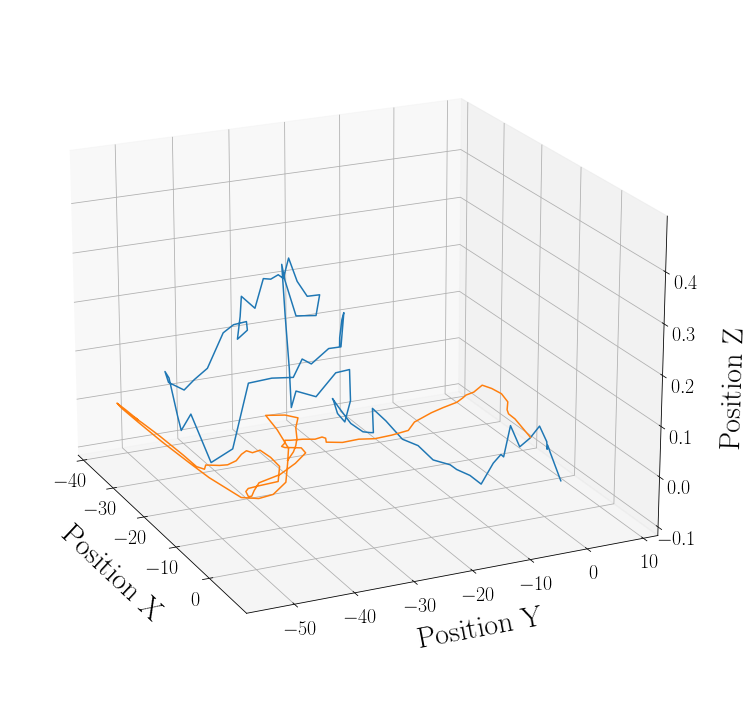

In [15]:
data = pd.read_csv("../data/cleaned/data_increase/intra_120/preds_120traj_COS_EU_intra/LENS_P18_14_01_2016_INSP_CPAP_bl_1.csv")
acum = data.cumsum()
print(acum)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.plot3D(acum.loc[:, "Rx_dif"], acum.loc[:, "Ry_dif"], acum.loc[:, "Rz_dif"])
ax.plot3D(acum.loc[:, "gt_Rx_dif"], acum.loc[:, "gt_Ry_dif"], acum.loc[:, "gt_Rz_dif"], )

ax.view_init(20, -25)
ax.set_ylabel("Position Y", fontsize=30, labelpad=20)
ax.set_xlabel("Position X", fontsize=30, labelpad=20)
ax.set_zlabel("Position Z", fontsize=30, labelpad=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.zaxis.set_tick_params(labelsize=20)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
fig.savefig("sample_traj_intra_loss.pdf", format='pdf', bbox_inches='tight')

# Draw data increase curves

In [13]:
intras = {
    "15": {"AAPE": [0.33815827798620524, 0.20463047521069128], "AACE": [0.18175232410430908, 0.23659560084342957]},
    "30": {"AAPE": [0.2576046555180582, 0.16910640137415348], "AACE": [0.1372830867767334, 0.19212055206298828]},
    "60": {"AAPE": [0.24582572343766432, 0.1473767351635224], "AACE": [0.07209256291389465, 0.14451491832733154]},
    "120": {"AAPE": [0.1892712760572946, 0.1189514274905981], "AACE": [0.03923159837722778, 0.10341912508010864]}
}

outers = {
    "15":{"AAPE": [0.7726174401041692, 0.3531318667521334], "AACE": [0.4127771258354187, 0.305209755897522]},
    "30": {"AAPE": [0.7561274635469625, 0.3448207091470282], "AACE": [0.3631901741027832, 0.30572810769081116]},
    "60": {"AAPE": [0.7487262669974284, 0.34122636935357165], "AACE": [0.30623823404312134, 0.3037383258342743]},
    "120": {"AAPE": [0.741318184442516, 0.33942156852382965], "AACE": [0.27053242921829224, 0.2927328646183014]}
}

In [14]:
import matplotlib.pyplot as plt

In [61]:
def plot_increase(dictio, dictio2):
    AAPE1, AACE1 = [], []
    for key, item in dictio.items():
        AAPE1.append(dictio[key]["AAPE"][0])
        AACE1.append(dictio[key]["AACE"][0])
    AAPE2, AACE2 = [], []
    for key, item in dictio.items():
        AAPE2.append(dictio2[key]["AAPE"][0])
        AACE2.append(dictio2[key]["AACE"][0])
    fig,ax = plt.subplots(figsize=(7, 6))
    ax.plot([15, 30, 60, 120], AAPE1, 'g-o', linewidth=2, linestyle=':')
    ax.plot([15, 30, 60, 120], AAPE2, 'r-o', linewidth=2, linestyle=':')
    ax.set_xlabel('N Sequences', fontsize=20)
    ax.set_ylabel('APE', fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax2 = ax.twinx()
    ax2.plot([15, 30, 60, 120], AACE1, 'g-s', linewidth=1)
    ax2.plot([15, 30, 60, 120], AACE2, 'r-s', linewidth=1)
    ax2.tick_params(axis="y", labelsize=20)
    ax2.set_ylabel('ACE', fontsize=20)
    fig.savefig("data_increase.pdf", format='pdf', bbox_inches='tight')

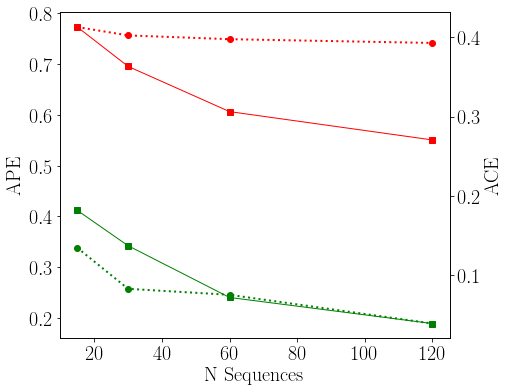

In [62]:
plot_increase(intras, outers)

# Prune 

In [2]:
aape = [0.329, 0.323, 0.319, 0.339, 0.330, 0.457]
aape_std = [0.207, 0.199, 0.189, 0.190, 0.195, 0.239]
aace = [0.179, 0.168, 0.137, 0.120, 0.111, 0.221]
aace_std = [0.233, 0.228, 0.208, 0.202, 0.190, 0.247]
percent = [1, .9, .7, .5, .3, .1]
orig_size = 1410

In [9]:
def plot_prune(aap, aac, percent):
    fig,ax = plt.subplots(figsize=(7, 6))
    ax.plot(percent, aap, 'g-o', linewidth=2, linestyle=':')
    ax.set_xlabel('% original network size', fontsize=20)
    ax.set_ylabel('APE', fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax2 = ax.twinx()
    ax2.plot(percent, aac, 'g-s', linewidth=1)
    ax2.tick_params(axis="y", labelsize=20)
    ax2.set_ylabel('ACE', fontsize=20)
    fig.savefig("data_prune.pdf", format='pdf', bbox_inches='tight')

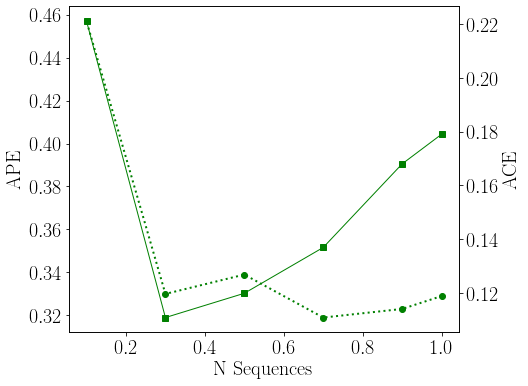

In [10]:
plot_prune(aape, aace, percent)

In [67]:
def plot_prune_2(aap, aac, percent):
    fig,ax = plt.subplots(figsize=(7, 6))
    sc = ax.scatter(aac, aap, s=np.array(percent, dtype=np.float32)*orig_size, c='g')
    ax.set_xlabel('ACE', fontsize=20)
    ax.set_ylabel('APE', fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    print(*sc.legend_elements("sizes", num=6))
    plt.legend(sc.legend_elements("sizes", num=7)[0], [0.1, 0.3, 0.5, 0.7, 0.9, 1.], bbox_to_anchor = (1.4, 1.), prop={'size': 25})
    plt.gca().invert_xaxis()
    fig.savefig("data_prune_2.pdf", format='pdf', bbox_inches='tight')


[<matplotlib.lines.Line2D object at 0x7ff24fae48d0>, <matplotlib.lines.Line2D object at 0x7ff24fae4a20>, <matplotlib.lines.Line2D object at 0x7ff24fae49e8>, <matplotlib.lines.Line2D object at 0x7ff24fae49b0>, <matplotlib.lines.Line2D object at 0x7ff24fae4ac8>] ['$\\mathdefault{250}$', '$\\mathdefault{500}$', '$\\mathdefault{750}$', '$\\mathdefault{1000}$', '$\\mathdefault{1250}$']


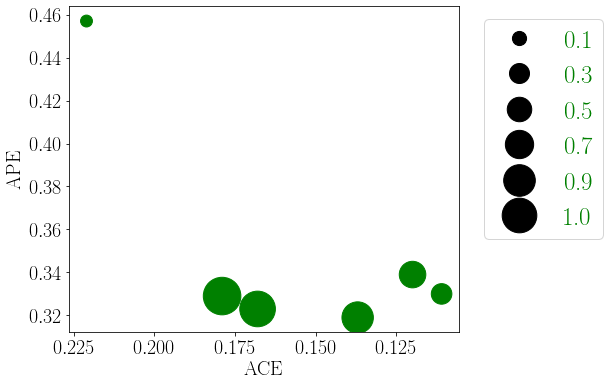

In [68]:
plot_prune_2(aape, aace, percent)

In [35]:
np.array(percent, dtype=np.int32)*orig_size


array([1410,    0,    0,    0,    0,    0], dtype=int32)